In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
!pip install imbalanced-learn

     |████████████████████████████████| 167 kB 11.2 MB/s eta 0:00:01


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle

from scipy.sparse import hstack, csr_matrix
from nltk.tokenize import RegexpTokenizer, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.ensemble import RUSBoostClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve, plot_roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split

import warnings; warnings.simplefilter('ignore')

In [4]:
T = 50  #set threshold parameter for "popular recipe"
t1 = pd.Timestamp('2016-12-31') #set initial time parameter upon which to base predictions.  Constraint:  t1 > 01-01-2001 + (t2 - t1)
t2 = pd.Timestamp('2018-01-30') #set prediction time parameter

In [5]:
days = pd.Timedelta((((t2 - t1).days // 365) + 1)*365,unit='D')

m1 = t1 - days # go back to previous time for model-training purposes
m2 = m1 + (t2 - t1)

m1,m2

(Timestamp('2015-01-01 00:00:00'), Timestamp('2016-01-31 00:00:00'))

In [6]:
recipes = pd.read_csv('https://raw.githubusercontent.com/mpc02002/Food.com_data/master/datasets-raw/RAW_recipes1.csv',index_col=0)
for i in [2,3,4,5]:
    recipes_append = pd.read_csv('https://raw.githubusercontent.com/mpc02002/Food.com_data/master/datasets-raw/RAW_recipes'+str(i)+'.csv',index_col=0)
    recipes = pd.concat([recipes,recipes_append],ignore_index=True)
recipes.set_index('id',inplace=True)

recipes

,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
id,,,,,,,,,,,
137739,arriba baked winter squash mexican style,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
31490,a bit different breakfast pizza,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
112140,all in the kitchen chili,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
59389,alouette potatoes,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
44061,amish tomato ketchup for canning,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
...,...,...,...,...,...,...,...,...,...,...,...
486161,zydeco soup,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22
493372,zydeco spice mix,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13
308080,zydeco ya ya deviled eggs,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8


In [7]:
interactions = pd.read_csv('https://raw.githubusercontent.com/mpc02002/Food.com_data/master/datasets-raw/RAW_interactions1.csv',index_col=0)
for i in [2,3,4,5]:
    inappend = pd.read_csv('https://raw.githubusercontent.com/mpc02002/Food.com_data/master/datasets-raw/RAW_interactions'+str(i)+'.csv',index_col=0)
    interactions = pd.concat([interactions,inappend],ignore_index=True)

interactions

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


In [8]:
interactions_pre_m1 = interactions[interactions['date'] <= m1]
interactions_pre_m2 = interactions[interactions['date'] <= m2]
interactions_pre_t1 = interactions[interactions['date'] <= t1]
interactions_pre_t2 = interactions[interactions['date'] <= t2]

recipe_ratings_count_m1 = (interactions_pre_m1.groupby('recipe_id').agg({'rating':'count'})
    .rename(columns={'rating':'total_ratings_at_m1'}))
recipe_ratings_count_m2 = (interactions_pre_m2.groupby('recipe_id').agg({'rating':'count'})
    .rename(columns={'rating':'total_ratings_at_m2'}))
recipe_ratings_count_t1 = (interactions_pre_t1.groupby('recipe_id').agg({'rating':'count'})
    .rename(columns={'rating':'total_ratings_at_t1'}))
recipe_ratings_count_t2 = (interactions_pre_t2.groupby('recipe_id').agg({'rating':'count'})
    .rename(columns={'rating':'total_ratings_at_t2'}))
recipe_ratings_count = pd.merge(recipe_ratings_count_m1,recipe_ratings_count_m2,how='outer',left_index=True,right_index=True)
recipe_ratings_count = pd.merge(recipe_ratings_count,recipe_ratings_count_t1,how='outer',left_index=True,right_index=True)
recipe_ratings_count = pd.merge(recipe_ratings_count,recipe_ratings_count_t2,how='outer',left_index=True,right_index=True)
recipe_ratings_count['total_ratings_at_m1'] = recipe_ratings_count['total_ratings_at_m1'].fillna(0).astype(int)
recipe_ratings_count['total_ratings_at_m2'] = recipe_ratings_count['total_ratings_at_m2'].fillna(0).astype(int)
recipe_ratings_count['total_ratings_at_t1'] = recipe_ratings_count['total_ratings_at_t1'].fillna(0).astype(int)
recipe_ratings_count

,total_ratings_at_m1,total_ratings_at_m2,total_ratings_at_t1,total_ratings_at_t2
recipe_id,,,,
38,4,4,4,4
39,1,1,1,1
40,9,9,9,9
41,2,2,2,2
43,1,1,1,1
...,...,...,...,...
534635,0,0,0,1
534784,0,0,0,1
534868,0,0,0,1


In [9]:
print('The proportion of recipes with at least ' + str(T) + ' ratings on ' + str(m1) + ' is ' + 
      str(len(recipe_ratings_count[recipe_ratings_count['total_ratings_at_m1'] >= T]) 
          / len(recipe_ratings_count)) + '.')
print('The proportion of recipes with at least ' + str(T) + ' ratings on ' + str(m2) + ' is ' + 
      str(len(recipe_ratings_count[recipe_ratings_count['total_ratings_at_m2'] >= T]) 
          / len(recipe_ratings_count)) + '.')
print('The proportion of recipes with at least ' + str(T) + ' ratings on ' + str(t1) + ' is ' + 
      str(len(recipe_ratings_count[recipe_ratings_count['total_ratings_at_t1'] >= T]) 
          / len(recipe_ratings_count)) + '.')
print('The proportion of recipes with at least ' + str(T) + ' ratings on ' + str(t2) + ' is ' + 
      str(len(recipe_ratings_count[recipe_ratings_count['total_ratings_at_t2'] >= T]) 
          / len(recipe_ratings_count)) + '.')

The proportion of recipes with at least 50 ratings on 2015-01-01 00:00:00 is 0.008118868562804133.
The proportion of recipes with at least 50 ratings on 2016-01-31 00:00:00 is 0.008374751706610459.
The proportion of recipes with at least 50 ratings on 2016-12-31 00:00:00 is 0.0086176238431046.
The proportion of recipes with at least 50 ratings on 2018-01-30 00:00:00 is 0.009077346101468509.


In [23]:
recipe_ratings_count['m1_target'] = recipe_ratings_count['total_ratings_at_m1'].map(lambda x: x >= T).astype(int)
recipe_ratings_count['m2_target'] = recipe_ratings_count['total_ratings_at_m2'].map(lambda x: x >= T).astype(int)
recipe_ratings_count['t1_target'] = recipe_ratings_count['total_ratings_at_t1'].map(lambda x: x >= T).astype(int)
recipe_ratings_count['t2_target'] = recipe_ratings_count['total_ratings_at_t2'].map(lambda x: x >= T).astype(int)
recipe_ratings_count

,total_ratings_at_m1,total_ratings_at_m2,total_ratings_at_t1,total_ratings_at_t2,m1_target,m2_target,t1_target,t2_target
recipe_id,,,,,,,,
38,4,4,4,4,0,0,0,0
39,1,1,1,1,0,0,0,0
40,9,9,9,9,0,0,0,0
41,2,2,2,2,0,0,0,0
43,1,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...
534635,0,0,0,1,0,0,0,0
534784,0,0,0,1,0,0,0,0
534868,0,0,0,1,0,0,0,0


In [11]:
df_train = (recipe_ratings_count[['m2_target','total_ratings_at_m1']]
            .loc[recipe_ratings_count['m1_target'] == 0]
            .rename(columns={'m2_target':'target','total_ratings_at_m1':'total_ratings_curr'})
           )

df_train = pd.merge(df_train,recipes['submitted'],how='left',left_index=True,right_index=True)
df_train['submitted'] = pd.to_datetime(df_train['submitted'])
df_train['age_in_days'] = ((m1 - df_train['submitted']) / pd.Timedelta(1,'D')).astype(int)
df_train.drop(columns=['submitted'],inplace=True)
df_train = df_train.loc[df_train['age_in_days'] >= 0]

df_train

,target,total_ratings_curr,age_in_days
recipe_id,,,
38,0,4,5624
39,0,1,5604
40,0,9,5597
41,0,2,5599
43,0,1,5612
...,...,...,...
520245,0,0,3
520248,0,1,3
520250,0,1,3


In [12]:
df_train['rating_pace'] = df_train['total_ratings_curr'] / df_train['age_in_days']

In [13]:
inters_pre_m1 = interactions.loc[interactions['date'] < m1]
inters_pre_m1['review'].fillna('',inplace=True)
review_aggs = inters_pre_m1.groupby('recipe_id').agg({'review':(lambda x: ' '.join(x))}).rename(columns={'review':'review_agg'})
              
review_aggs

,review_agg
recipe_id,
38,"Yummy, yummy, yummy! I am a big fan of fruit a..."
39,I have an Indian friend who made this dish for...
40,My favourite lemonade recipe is essentially th...
41,I thought this was very GOOD! ANYONE who is af...
43,did not work.
...,...
520055,Forget the takeout! This recipe took me to chi...
520067,WOWIE RATING FOR THIS SOUP!&lt;br/&gt; ...
520088,This recipe calls for walnuts and the instruct...


In [14]:
df_train = pd.merge(df_train,review_aggs,how='left',left_index=True,right_index=True)
df_train['review_agg'].fillna('',inplace=True)

df_train

,target,total_ratings_curr,age_in_days,rating_pace,review_agg
recipe_id,,,,,
38,0,4,5624,0.000711,"Yummy, yummy, yummy! I am a big fan of fruit a..."
39,0,1,5604,0.000178,I have an Indian friend who made this dish for...
40,0,9,5597,0.001608,My favourite lemonade recipe is essentially th...
41,0,2,5599,0.000357,I thought this was very GOOD! ANYONE who is af...
43,0,1,5612,0.000178,did not work.
...,...,...,...,...,...
520245,0,0,3,0.000000,
520248,0,1,3,0.333333,"This is really good and so easy., I made it fo..."
520250,0,1,3,0.333333,


In [15]:
vect = CountVectorizer(min_df=3).fit(df_train['review_agg'])

df_train_reviews_vectorized = vect.transform(df_train['review_agg'])


In [16]:
X_train = hstack([df_train['total_ratings_curr'].values.reshape(-1,1),df_train_reviews_vectorized])
y_train = df_train['target'].values.reshape(-1,1)

X_train.shape, y_train.shape

((228039, 42965), (228039, 1))

In [17]:
RUSNB_clfr = RUSBoostClassifier(base_estimator=MultinomialNB(alpha=0.01),sampling_strategy=0.2,random_state=0).fit(X_train, y_train)

predict_probas = RUSNB_clfr.predict_proba(X_train)[:,1]
predictions = (predict_probas > 0.49)
        
roc_auc_score(y_train,predict_probas), recall_score(y_train,predictions), precision_score(y_train,predictions)

(0.888712217246174, 1.0, 0.001070782409629657)

In [21]:
project.save_data('vect_and_RUSNB_clfr.pkl', pickle.dumps((vect, RUSNB_clfr)), set_project_asset=True, overwrite=True)



{'file_name': 'vect_and_RUSNB_clfr.pkl',
 'message': 'File saved to project storage.',
 'bucket_name': 'foodcomrecipepopularitypredictor-donotdelete-pr-wiqbzxzcs7ksbf',
 'asset_id': 'cbd1ac25-a4b4-4c4f-a527-da7308ca8867'}

In [57]:
df_train['RUSNB_proba_pred'] = predict_probas

df_train

,target,total_ratings_curr,age_in_days,review_agg,RUSNB_proba_pred
recipe_id,,,,,
38,0,4,5624,"Yummy, yummy, yummy! I am a big fan of fruit a...",1.157203e-01
39,0,1,5604,I have an Indian friend who made this dish for...,1.524663e-02
40,0,9,5597,My favourite lemonade recipe is essentially th...,5.000000e-01
41,0,2,5599,I thought this was very GOOD! ANYONE who is af...,4.450527e-03
43,0,1,5612,did not work.,3.428655e-08
...,...,...,...,...,...
520245,0,0,3,,1.325268e-08
520248,0,1,3,"This is really good and so easy., I made it fo...",1.084453e-01
520250,0,1,3,,2.167725e-08


In [59]:
len(df_train[df_train['RUSNB_proba_pred'] > .49]), len(df_train[df_train['target'] == 1])

(54166, 58)

In [60]:
df_train = df_train.drop(columns='review_agg')

df_train

,target,total_ratings_curr,age_in_days,RUSNB_proba_pred
recipe_id,,,,
38,0,4,5624,1.157203e-01
39,0,1,5604,1.524663e-02
40,0,9,5597,5.000000e-01
41,0,2,5599,4.450527e-03
43,0,1,5612,3.428655e-08
...,...,...,...,...
520245,0,0,3,1.325268e-08
520248,0,1,3,1.084453e-01
520250,0,1,3,2.167725e-08


In [32]:
mean_rating_at_m1 = inters_pre_m1.groupby('recipe_id').mean().rename(columns={'rating':'mean_rating_at_m1'})
mean_rating_at_m1

,user_id,mean_rating_at_m1
recipe_id,,
38,4.516842e+08,4.250000
39,3.932540e+05,3.000000
40,4.048043e+05,4.333333
41,5.588705e+05,4.500000
43,1.060485e+06,1.000000
...,...,...
520055,1.803588e+09,5.000000
520067,2.505890e+05,5.000000
520088,2.196530e+05,0.000000


In [61]:
df_train = pd.merge(df_train,mean_rating_at_m1['mean_rating_at_m1'],how='left',left_index=True,right_index=True)

df_train

,target,total_ratings_curr,age_in_days,RUSNB_proba_pred,mean_rating_at_m1
recipe_id,,,,,
38,0,4,5624,1.157203e-01,4.250000
39,0,1,5604,1.524663e-02,3.000000
40,0,9,5597,5.000000e-01,4.333333
41,0,2,5599,4.450527e-03,4.500000
43,0,1,5612,3.428655e-08,1.000000
...,...,...,...,...,...
520245,0,0,3,1.325268e-08,NaN
520248,0,1,3,1.084453e-01,5.000000
520250,0,1,3,2.167725e-08,NaN


In [62]:
df_train.rename(columns={'mean_rating_at_m1':'mean_rating_curr'},inplace=True)
df_train['mean_rating_curr'].fillna(0,inplace=True)

df_train

,target,total_ratings_curr,age_in_days,RUSNB_proba_pred,mean_rating_curr
recipe_id,,,,,
38,0,4,5624,1.157203e-01,4.250000
39,0,1,5604,1.524663e-02,3.000000
40,0,9,5597,5.000000e-01,4.333333
41,0,2,5599,4.450527e-03,4.500000
43,0,1,5612,3.428655e-08,1.000000
...,...,...,...,...,...
520245,0,0,3,1.325268e-08,0.000000
520248,0,1,3,1.084453e-01,5.000000
520250,0,1,3,2.167725e-08,0.000000


In [63]:
df_train = pd.merge(df_train,recipes[['minutes','n_steps','n_ingredients']],how='left',left_index=True,right_index=True)

df_train

,target,total_ratings_curr,age_in_days,RUSNB_proba_pred,mean_rating_curr,minutes,submitted,n_steps,n_ingredients
recipe_id,,,,,,,,,
38,0,4,5624,1.157203e-01,4.250000,1485,1999-08-09,13,4
39,0,1,5604,1.524663e-02,3.000000,265,1999-08-29,17,26
40,0,9,5597,5.000000e-01,4.333333,35,1999-09-05,8,6
41,0,2,5599,4.450527e-03,4.500000,1460,1999-09-03,18,15
43,0,1,5612,3.428655e-08,1.000000,140,1999-08-21,35,15
...,...,...,...,...,...,...,...,...,...
520245,0,0,3,1.325268e-08,0.000000,35,2014-12-29,10,6
520248,0,1,3,1.084453e-01,5.000000,15,2014-12-29,9,7
520250,0,1,3,2.167725e-08,0.000000,30,2014-12-29,11,12


In [66]:
df_train = pd.merge(df_train,recipes['nutrition'],how='left',left_index=True,right_index=True)

In [67]:
df_train['calories'] = df_train['nutrition'].str.extract(r'[[]([^,]*)')
df_train

,target,total_ratings_curr,age_in_days,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,nutrition,calories
recipe_id,,,,,,,,,,
38,0,4,5624,1.157203e-01,4.250000,1485,13,4,"[170.9, 3.0, 120.0, 1.0, 6.0, 6.0, 12.0]",170.9
39,0,1,5604,1.524663e-02,3.000000,265,17,26,"[1110.7, 90.0, 81.0, 15.0, 126.0, 82.0, 28.0]",1110.7
40,0,9,5597,5.000000e-01,4.333333,35,8,6,"[311.1, 0.0, 308.0, 0.0, 0.0, 0.0, 27.0]",311.1
41,0,2,5599,4.450527e-03,4.500000,1460,18,15,"[536.1, 36.0, 128.0, 64.0, 58.0, 19.0, 21.0]",536.1
43,0,1,5612,3.428655e-08,1.000000,140,35,15,"[437.9, 29.0, 170.0, 11.0, 13.0, 54.0, 19.0]",437.9
...,...,...,...,...,...,...,...,...,...,...
520245,0,0,3,1.325268e-08,0.000000,35,10,6,"[206.6, 27.0, 22.0, 26.0, 7.0, 55.0, 3.0]",206.6
520248,0,1,3,1.084453e-01,5.000000,15,9,7,"[473.7, 32.0, 21.0, 24.0, 50.0, 37.0, 15.0]",473.7
520250,0,1,3,2.167725e-08,0.000000,30,11,12,"[251.5, 20.0, 39.0, 2.0, 32.0, 21.0, 5.0]",251.5


In [68]:
df_train.drop(columns='nutrition',inplace=True)

In [69]:
df_train

,target,total_ratings_curr,age_in_days,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,calories
recipe_id,,,,,,,,,
38,0,4,5624,1.157203e-01,4.250000,1485,13,4,170.9
39,0,1,5604,1.524663e-02,3.000000,265,17,26,1110.7
40,0,9,5597,5.000000e-01,4.333333,35,8,6,311.1
41,0,2,5599,4.450527e-03,4.500000,1460,18,15,536.1
43,0,1,5612,3.428655e-08,1.000000,140,35,15,437.9
...,...,...,...,...,...,...,...,...,...
520245,0,0,3,1.325268e-08,0.000000,35,10,6,206.6
520248,0,1,3,1.084453e-01,5.000000,15,9,7,473.7
520250,0,1,3,2.167725e-08,0.000000,30,11,12,251.5


In [39]:
simple_word_tokenizer = RegexpTokenizer(r'\w+')

readability_df = recipes['steps'].to_frame().fillna('')
readability_df['steps_word_tokenized'] = readability_df['steps'].apply(simple_word_tokenizer.tokenize)
readability_df['long_words'] = readability_df['steps_word_tokenized'].apply(lambda x: [word for word in x if len(word) > 6])

readability_df = pd.merge(readability_df, recipes['n_steps'],how='left',left_index=True,right_index=True)
readability_df['num_words'] = readability_df['steps_word_tokenized'].apply(lambda x: len(x))
readability_df['num_long_words'] = readability_df['long_words'].apply(lambda x: len(x))

readability_df['LIX_score'] = 100 * readability_df['num_long_words'] / readability_df['num_words'] + readability_df['num_words'] / readability_df['n_steps']

In [70]:
df_train = pd.merge(df_train,readability_df['LIX_score'],how='left',left_index=True,right_index=True)

df_train

,target,total_ratings_curr,age_in_days,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,calories,LIX_score
recipe_id,,,,,,,,,,
38,0,4,5624,1.157203e-01,4.250000,1485,13,4,170.9,28.360140
39,0,1,5604,1.524663e-02,3.000000,265,17,26,1110.7,33.459893
40,0,9,5597,5.000000e-01,4.333333,35,8,6,311.1,15.944444
41,0,2,5599,4.450527e-03,4.500000,1460,18,15,536.1,31.488889
43,0,1,5612,3.428655e-08,1.000000,140,35,15,437.9,28.777387
...,...,...,...,...,...,...,...,...,...,...
520245,0,0,3,1.325268e-08,0.000000,35,10,6,206.6,31.076623
520248,0,1,3,1.084453e-01,5.000000,15,9,7,473.7,30.761905
520250,0,1,3,2.167725e-08,0.000000,30,11,12,251.5,31.080946


In [16]:
project.save_data('features_train.csv', df_train.to_csv(), set_project_asset=True, overwrite=True)

{'file_name': 'features_train.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'foodcomrecipepopularitypredictor-donotdelete-pr-wiqbzxzcs7ksbf',
 'asset_id': '07aeab73-aeed-4054-9647-d200350af9cf'}

In [9]:
#df_train = pd.read_csv(project.get_file('features_train.csv'),index_col=0)

#vect, RUSNB_clfr = pickle.load(project.get_file('vect_and_RUSNB_clfr.pkl'))

In [41]:
infile = project.get_file("ingr_map.pkl")
ingr_map = pickle.load(infile)
infile.close()
ingr_map.set_index('id',inplace=True)
ingr_map

,raw_ingr,raw_words,processed,len_proc,replaced,count
id,,,,,,
4308,"medium heads bibb or red leaf lettuce, washed,...",13,"medium heads bibb or red leaf lettuce, washed,...",73,lettuce,4507
4308,mixed baby lettuces and spring greens,6,mixed baby lettuces and spring green,36,lettuce,4507
4308,romaine lettuce leaf,3,romaine lettuce leaf,20,lettuce,4507
4308,iceberg lettuce leaf,3,iceberg lettuce leaf,20,lettuce,4507
4308,red romaine lettuce,3,red romaine lettuce,19,lettuce,4507
...,...,...,...,...,...,...
6702,soybeans,1,soybean,7,soybean,31
3318,goose,1,goose,5,goose,8
47,ajwain,1,ajwain,6,ajwain,13


In [42]:
recipe_ingr_lists = recipes['ingredients'].str.extractall(r"'([^,]*)',").reset_index(level=1, drop=True).rename(columns={0:'raw_ingr'})
recipe_ingr_lists

,raw_ingr
id,
137739,winter squash
137739,mexican seasoning
137739,mixed spice
137739,honey
137739,butter
...,...
298509,shortening
298509,eggs
298509,flour


In [43]:
ingr_ids = ingr_map['raw_ingr'].reset_index().set_index('raw_ingr')
recipe_ingr_lists = pd.merge(recipe_ingr_lists,ingr_ids,how='left',left_on='raw_ingr',right_index=True)

In [44]:
recipes_to_ingrs = recipe_ingr_lists.drop(columns='raw_ingr').rename(columns={'id':'ingr_id'}).reset_index().rename(columns={'id':'recipe_id'})

recipes_to_ingrs = recipes_to_ingrs.loc[~recipes_to_ingrs['ingr_id'].isna()]

recipes_to_ingrs['ingr_id'] = recipes_to_ingrs['ingr_id'].astype(int)

recipes_to_ingrs

,recipe_id,ingr_id
0,137739,7933
1,137739,4694
2,137739,4795
3,137739,3723
4,137739,840
...,...,...
1854472,298509,6473
1854473,298509,2499
1854474,298509,2683
1854475,298509,1925


In [45]:
ingr_recipe_count = recipes_to_ingrs.groupby('ingr_id').count()
ingr_recipe_count.index = ingr_recipe_count.index.astype('int')
ingr_recipe_count.sort_index(inplace=True)
ingr_recipe_count.rename(columns={'recipe_id':'recipe_count'},inplace=True)

recipes_to_sig_ingrs = pd.merge(recipes_to_ingrs,ingr_recipe_count,how='left',left_on='ingr_id',right_index=True)
recipes_to_sig_ingrs = recipes_to_sig_ingrs[recipes_to_sig_ingrs['recipe_count'] >= 50]
recipes_to_sig_ingrs

,recipe_id,ingr_id,recipe_count
0,137739,7933,60
2,137739,4795,201
3,137739,3723,8827
4,137739,840,50435
5,137739,5006,38196
...,...,...,...
1854472,298509,6473,2610
1854473,298509,2499,48439
1854474,298509,2683,25246
1854475,298509,1925,941


In [46]:
num_recipes = len(recipe_ratings_count.index.unique())

recipes_to_sig_ingrs['ingr_rareness'] = recipes_to_sig_ingrs['recipe_count'] / num_recipes

recipes_to_sig_ingrs

,recipe_id,ingr_id,recipe_count,ingr_rareness
0,137739,7933,60,0.000260
2,137739,4795,201,0.000872
3,137739,3723,8827,0.038283
4,137739,840,50435,0.218737
5,137739,5006,38196,0.165656
...,...,...,...,...
1854472,298509,6473,2610,0.011320
1854473,298509,2499,48439,0.210080
1854474,298509,2683,25246,0.109492
1854475,298509,1925,941,0.004081


In [62]:
recipes_to_sig_ingrs.loc[recipes_to_sig_ingrs['ingr_rareness'].isna()]

,recipe_id,ingr_id,recipe_count,ingr_rareness


In [47]:
ingr_rareness_sums = recipes_to_sig_ingrs.groupby('recipe_id').agg({'ingr_rareness':'sum'}).rename(columns={'ingr_rareness':'ingr_rareness_sum'})

ingr_rareness_info = pd.merge(df_train['n_ingredients'],ingr_rareness_sums,how='left',left_index=True,right_index=True)
ingr_rareness_info['innovation_IDF'] = ingr_rareness_info['ingr_rareness_sum'] / ingr_rareness_info['n_ingredients']
ingr_rareness_info

,n_ingredients,ingr_rareness_sum,innovation_IDF
recipe_id,,,
38,4,0.032488,0.008122
39,26,1.151669,0.044295
40,6,0.206905,0.034484
41,15,0.546987,0.036466
43,15,1.105827,0.073722
...,...,...,...
520245,6,0.641686,0.106948
520248,7,0.139664,0.019952
520250,12,0.560839,0.046737


In [61]:
ingr_rareness_info.loc[ingr_rareness_info['innovation_IDF'].isna()]

,n_ingredients,ingr_rareness_sum,innovation_IDF
recipe_id,,,
147,2,NaN,NaN
310,1,NaN,NaN
2747,2,NaN,NaN
2881,2,NaN,NaN
8558,3,NaN,NaN
...,...,...,...
506226,3,NaN,NaN
510983,4,NaN,NaN
511085,2,NaN,NaN


In [63]:
recipes_to_sig_ingrs.loc[147]

name                                           campfire orange cake
minutes                                                          30
contributor_id                                                 1585
submitted                                                1999-08-28
tags              ['30-minutes-or-less', 'time-to-make', 'course...
nutrition               [332.5, 14.0, 153.0, 18.0, 7.0, 12.0, 19.0]
n_steps                                                           7
steps             ['you could probably do this with any cake mix...
description       when i was a child, my mother made orange cake...
ingredients                          ['gingerbread mix', 'oranges']
n_ingredients                                                     2
Name: 147, dtype: object

In [65]:
ingr_map.loc[ingr_map['raw_ingr'] == 'oranges']

,raw_ingr,raw_words,processed,len_proc,replaced,count
id,,,,,,
5038,oranges,1,orange,6,orange,1383


In [66]:
recipes_to_ingrs.loc[recipes_to_ingrs['ingr_id'] == 5038]

,recipe_id,ingr_id
1491,316470,5038
5685,79736,5038
7756,242259,5038
9534,112648,5038
11381,406071,5038
...,...,...
1842677,317343,5038
1845029,103766,5038
1845091,2514,5038
1845846,109634,5038


In [67]:
recipes_to_ingrs.loc[recipes_to_ingrs['recipe_id'] == 147]

,recipe_id,ingr_id
274036,147,3266


In [70]:
df_train = pd.merge(df_train,ingr_rareness_info['innovation_IDF'],how='left',left_index=True,right_index=True)
df_train

,target,total_ratings_curr,age_in_days,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,calories,LIX_score,innovation_IDF
recipe_id,,,,,,,,,,,
38,0,4,5624,1.157203e-01,4.250000,1485,13,4,170.9,28.360140,0.008122
39,0,1,5604,1.524663e-02,3.000000,265,17,26,1110.7,33.459893,0.044295
40,0,9,5597,5.000000e-01,4.333333,35,8,6,311.1,15.944444,0.034484
41,0,2,5599,4.450527e-03,4.500000,1460,18,15,536.1,31.488889,0.036466
43,0,1,5612,3.428655e-08,1.000000,140,35,15,437.9,28.777387,0.073722
...,...,...,...,...,...,...,...,...,...,...,...
520245,0,0,3,1.325268e-08,0.000000,35,10,6,206.6,31.076623,0.106948
520248,0,1,3,1.084453e-01,5.000000,15,9,7,473.7,30.761905,0.019952
520250,0,1,3,2.167725e-08,0.000000,30,11,12,251.5,31.080946,0.046737


In [72]:
df_train['innovation_IDF'].fillna(0,inplace=True)

df_train.loc[df_train['innovation_IDF'].isna()]

,target,total_ratings_curr,age_in_days,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,calories,LIX_score,innovation_IDF
recipe_id,,,,,,,,,,,


In [51]:
edges = recipes_to_sig_ingrs[['recipe_id','ingr_id']]
edges['ingr_id'] = edges['ingr_id'].astype('float') / 10000
edges

,recipe_id,ingr_id
0,137739,0.7933
2,137739,0.4795
3,137739,0.3723
4,137739,0.0840
5,137739,0.5006
...,...,...
1854472,298509,0.6473
1854473,298509,0.2499
1854474,298509,0.2683
1854475,298509,0.1925


In [52]:
G = nx.from_pandas_edgelist(edges,'recipe_id','ingr_id')

In [53]:
nx.is_bipartite(G)

True

In [83]:
popular_recipes_at_m1 = recipe_ratings_count[recipe_ratings_count['total_ratings_at_m1'] >= 50].index.to_list()
popular_recipes_at_m1 = [r for r in popular_recipes_at_m1 if r in G.nodes()]

candidate_recipes = df_train[df_train['RUSNB_proba_pred'] > .49].index.to_list()
candidate_recipes = [r for r in candidate_recipes if r in G.nodes()]

In [84]:
df_train['innovation_jaccard'] = [None for i in df_train.index]
df_train['innovation_jaccard_avg'] = [None for i in df_train.index]

for r in candidate_recipes:
    r_duplicates = np.array([r for i in popular_recipes])
    jaccard_coeffs = [p for u,v,p in nx.jaccard_coefficient(G,zip(r_duplicates,popular_recipes_at_m1))]
    df_train['innovation_jaccard'].loc[r] = 1 - max(jaccard_coeffs)
    df_train['innovation_jaccard_avg'].loc[r] = 1 - np.mean(jaccard_coeffs)

#df_train['innovation_jaccard'].fillna(0,inplace=True)
#df_train['innovation_jaccard_avg'].fillna(0,inplace=True)

project.save_data('features_train.csv', df_train.to_csv(), set_project_asset=True, overwrite=True)

df_train

,target,total_ratings_curr,age_in_days,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,calories,LIX_score,innovation_IDF,innovation_jaccard,innovation_jaccard_avg
recipe_id,,,,,,,,,,,,,
38,0,4,5624,1.157203e-01,4.250000,1485,13,4,170.9,28.360140,0.008122,None,None
39,0,1,5604,1.524663e-02,3.000000,265,17,26,1110.7,33.459893,0.044295,None,None
40,0,9,5597,5.000000e-01,4.333333,35,8,6,311.1,15.944444,0.034484,0.5,0.975533
41,0,2,5599,4.450527e-03,4.500000,1460,18,15,536.1,31.488889,0.036466,None,None
43,0,1,5612,3.428655e-08,1.000000,140,35,15,437.9,28.777387,0.073722,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
520245,0,0,3,1.325268e-08,0.000000,35,10,6,206.6,31.076623,0.106948,None,None
520248,0,1,3,1.084453e-01,5.000000,15,9,7,473.7,30.761905,0.019952,None,None
520250,0,1,3,2.167725e-08,0.000000,30,11,12,251.5,31.080946,0.046737,None,None


In [85]:
df_train.loc[~df_train['innovation_jaccard'].isna()]

,target,total_ratings_curr,age_in_days,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,calories,LIX_score,innovation_IDF,innovation_jaccard,innovation_jaccard_avg
recipe_id,,,,,,,,,,,,,
40,0,9,5597,0.500000,4.333333,35,8,6,311.1,15.944444,0.034484,0.5,0.975533
49,0,18,5619,0.500000,4.277778,75,22,10,627.7,32.621735,0.079699,0.642857,0.932288
58,0,7,5619,0.500000,4.428571,164,16,12,280.1,18.491848,0.049274,0.636364,0.952544
62,0,22,5614,0.500000,4.681818,25,4,9,407.8,32.658163,0.030537,0.769231,0.984925
66,0,18,5592,0.500000,4.944444,30,3,11,772.0,35.617886,0.040499,0.692308,0.973757
...,...,...,...,...,...,...,...,...,...,...,...,...,...
517904,0,3,141,0.500000,4.333333,40,12,8,217.9,20.887681,0.100682,0.5,0.921499
518015,0,16,136,0.500000,4.687500,140,19,15,368.9,24.544036,0.047936,0.761905,0.956613
518145,0,25,129,0.495542,4.800000,145,22,18,440.2,26.041553,0.037077,0.809524,0.963827


In [17]:
df_train.fillna(0,inplace=True)

In [18]:
df_train

,target,total_ratings_curr,age_in_days,rating_pace,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,calories,LIX_score,innovation_IDF,innovation_jaccard,innovation_jaccard_avg
recipe_id,,,,,,,,,,,,,,
38,0,4,5624,0.000711,1.157203e-01,4.250000,1485,13,4,170.9,28.360140,0.008122,0.0,0.000000
39,0,1,5604,0.000178,1.524663e-02,3.000000,265,17,26,1110.7,33.459893,0.044295,0.0,0.000000
40,0,9,5597,0.001608,5.000000e-01,4.333333,35,8,6,311.1,15.944444,0.034484,0.5,0.975533
41,0,2,5599,0.000357,4.450527e-03,4.500000,1460,18,15,536.1,31.488889,0.036466,0.0,0.000000
43,0,1,5612,0.000178,3.428655e-08,1.000000,140,35,15,437.9,28.777387,0.073722,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520245,0,0,3,0.000000,1.325268e-08,0.000000,35,10,6,206.6,31.076623,0.106948,0.0,0.000000
520248,0,1,3,0.333333,1.084453e-01,5.000000,15,9,7,473.7,30.761905,0.019952,0.0,0.000000
520250,0,1,3,0.333333,2.167725e-08,0.000000,30,11,12,251.5,31.080946,0.046737,0.0,0.000000


In [19]:
X_train = df_train.drop(columns='target')
y_train = df_train['target']

In [130]:
LR_clfr = LogisticRegression()
DT_clfr = DecisionTreeClassifier()

cross_val_score(LR_clfr, X_train, y_train, cv=10, scoring='roc_auc'), cross_val_score(DT_clfr, X_train, y_train, cv=10, scoring='roc_auc')

(array([0.99560507, 0.99524081, 0.99570869, 0.99807732, 0.99499956,
        0.99896921, 0.99939322, 0.99980261, 0.99938591, 0.99934205]),
 array([0.7988596 , 0.58296049, 0.74947364, 0.49975875, 0.58276311,
        0.49995614, 0.66664473, 0.49989034, 0.58333333, 0.79995614]))

In [131]:
cross_val_score(LR_clfr, X_train, y_train, cv=10, scoring='recall'), cross_val_score(DT_clfr, X_train, y_train, cv=10, scoring='recall')

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.16666667, 0.16666667, 0.6       ]),
 array([0.6       , 0.16666667, 0.66666667, 0.16666667, 0.16666667,
        0.        , 0.33333333, 0.16666667, 0.16666667, 0.6       ]))

In [132]:
cross_val_score(LR_clfr, X_train, y_train, cv=10, scoring='precision'), cross_val_score(DT_clfr, X_train, y_train, cv=10, scoring='precision')

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.5       , 0.5       , 0.17647059]),
 array([0.05555556, 0.05882353, 0.14814815, 0.15384615, 0.04166667,
        0.        , 0.5       , 0.        , 1.        , 0.33333333]))

In [133]:
cross_val_score(LR_clfr, X_train, y_train, cv=10, scoring='f1'), cross_val_score(DT_clfr, X_train, y_train, cv=10, scoring='f1')

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.25      , 0.25      , 0.27272727]),
 array([0.09836066, 0.08695652, 0.23529412, 0.2       , 0.06666667,
        0.        , 0.5       , 0.        , 0.28571429, 0.5       ]))

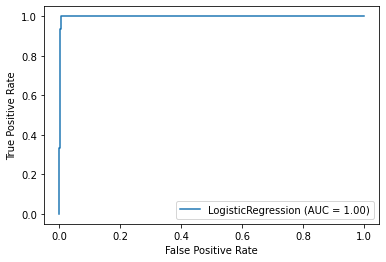

In [160]:
X_train_0,X_test_0,y_train_0,y_test_0 = train_test_split(X_train,y_train)

plot_roc_curve(LR_clfr.fit(X_train_0,y_train_0), X_test_0, y_test_0)
plt.show()

In [161]:
fpr, tpr, thresholds = roc_curve(y_test_0,LR_clfr.fit(X_train_0,y_train_0).predict_proba(X_test_0)[:,1])

thresholds[np.argmax(tpr - fpr)], thresholds[np.argmax(np.sqrt(tpr * (1 - fpr)))]

(0.0032088775719609336, 0.0032088775719609336)

In [162]:
tpr[np.argmax(tpr - fpr)], fpr[np.argmax(tpr - fpr)]

(1.0, 0.00461443986314589)

In [164]:
LR_predict_probas = LR_clfr.fit(X_train_0,y_train_0).predict_proba(X_test_0)[:,1]
LR_predictions = (LR_predict_probas >= 0.002)

LR_predictions_compare = y_test_0.to_frame()
LR_predictions_compare['LR_predict_proba'] = LR_predict_probas
LR_predictions_compare['LR_prediction'] = LR_predictions

LR_predictions_compare.sort_values('LR_predict_proba',ascending=False).iloc[:50]

,target,LR_predict_proba,LR_prediction
recipe_id,,,
30470,0,0.912836,True
418682,1,0.799929,True
514791,0,0.790425,True
157068,0,0.712964,True
254025,0,0.603791,True
321948,0,0.598228,True
10155,0,0.450349,True
112889,1,0.407790,True
63746,0,0.395747,True


In [142]:
df_train.loc[165254]

target                       1.000000
total_ratings_curr          44.000000
age_in_days               3174.000000
RUSNB_proba_pred             0.500000
mean_rating_curr             4.500000
minutes                     30.000000
n_steps                     17.000000
n_ingredients                4.000000
calories                   178.000000
LIX_score                   25.205198
innovation_IDF               0.006653
innovation_jaccard           0.600000
innovation_jaccard_avg       0.996556
rating_pace                  0.013863
Name: 165254, dtype: float64

In [143]:
recall_score(y_test_0,predictions), precision_score(y_test_0,predictions)

(0.25, 0.2)

In [153]:
LR_clfr.coef_

array([[ 2.40286219e-01, -1.07485180e-03, -4.62949083e-02,
        -6.43181243e-01, -1.35174896e-02,  7.17596860e-02,
        -2.13550154e-01,  6.97474254e-05, -1.94070050e-01,
         2.64954981e-04, -4.29138046e-02, -5.71513840e-02,
        -4.26250835e-03]])

In [152]:
GB_clfr = GradientBoostingClassifier()

cross_val_score(GB_clfr, X_train, y_train, cv=5, scoring='roc_auc')

array([0.99871602, 0.7499342 , 0.91647111, 0.20823738, 0.99853855])

In [20]:
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)

X_train_scaled

array([[8.16326531e-02, 9.99466761e-01, 2.13371266e-03, ...,
        4.21909321e-02, 0.00000000e+00, 0.00000000e+00],
       [2.04081633e-02, 9.95911838e-01, 5.35331906e-04, ...,
        2.30093365e-01, 0.00000000e+00, 0.00000000e+00],
       [1.83673469e-01, 9.94667615e-01, 4.82401286e-03, ...,
        1.79130761e-01, 5.00000000e-01, 9.75532974e-01],
       ...,
       [2.04081633e-02, 3.55492357e-04, 1.00000000e+00, ...,
        2.42776683e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.77746178e-04, 0.00000000e+00, ...,
        1.75979897e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.09643159e-02, 0.00000000e+00, 0.00000000e+00]])

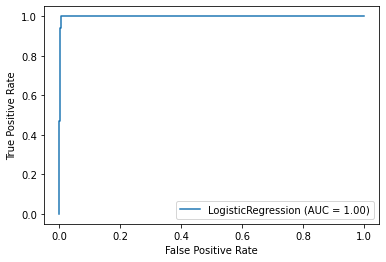

In [166]:
X_train_scaled_0,X_test_scaled_0,y_train_0,y_test_0 = train_test_split(X_train_scaled,y_train)

plot_roc_curve(LR_clfr.fit(X_train_scaled_0,y_train_0), X_test_scaled_0, y_test_0)
plt.show()

In [167]:
fpr, tpr, thresholds = roc_curve(y_test_0,LR_clfr.fit(X_train_scaled_0,y_train_0).predict_proba(X_test_scaled_0)[:,1])

thresholds[np.argmax(tpr - fpr)], thresholds[np.argmax(np.sqrt(tpr * (1 - fpr)))]

(0.00707286453013449, 0.00707286453013449)

In [168]:
LR_predict_probas = LR_clfr.fit(X_train_scaled_0,y_train_0).predict_proba(X_test_scaled_0)[:,1]
LR_predictions = (LR_predict_probas >= 0.007)

LR_predictions_compare = y_test_0.to_frame()
LR_predictions_compare['LR_predict_proba'] = LR_predict_probas
LR_predictions_compare['LR_prediction'] = LR_predictions

LR_predictions_compare.sort_values('LR_predict_proba',ascending=False).iloc[:50]

,target,LR_predict_proba,LR_prediction
recipe_id,,,
240456,1,0.104497,True
475446,0,0.103154,True
111652,0,0.098755,True
95352,1,0.097136,True
131841,1,0.095621,True
73061,0,0.093629,True
84828,1,0.093470,True
63746,0,0.092431,True
59900,1,0.091011,True


In [21]:
LR_clfr = LogisticRegression().fit(X_train_scaled,y_train)

X_train.columns, LR_clfr.coef_

(Index(['total_ratings_curr', 'age_in_days', 'rating_pace', 'RUSNB_proba_pred',
        'mean_rating_curr', 'minutes', 'n_steps', 'n_ingredients', 'calories',
        'LIX_score', 'innovation_IDF', 'innovation_jaccard',
        'innovation_jaccard_avg'],
       dtype='object'),
 array([[ 9.33065294e+00, -1.09467408e+00,  3.03710451e-01,
          5.04020846e-01, -6.24737022e-01, -3.22222014e-04,
          4.64697895e-01,  2.77993747e-01,  2.81280129e-03,
         -3.88622109e-01,  6.23021626e-01,  2.51475244e-01,
          8.83593930e-01]]))

In [195]:
RUSLG_clfr = RUSBoostClassifier(base_estimator=LogisticRegression(),sampling_strategy=.2,random_state=0).fit(X_train_scaled_0, y_train_0)

RUSLG_predict_probas = RUSLG_clfr.predict_proba(X_test_scaled_0)[:,1]
RUSLG_predictions = (RUSLG_predict_probas > 0.4)
        
roc_auc_score(y_test_0,RUSLG_predict_probas), recall_score(y_test_0,RUSLG_predictions), precision_score(y_test_0,RUSLG_predictions)

(0.9974898878190407, 1.0, 0.0002981932994211542)

In [196]:
RUSLG_predictions_compare = y_test_0.to_frame()
RUSLG_predictions_compare['RUSLG_predict_proba'] = RUSLG_predict_probas
RUSLG_predictions_compare['RUSLG_prediction'] = RUSLG_predictions

RUSLG_predictions_compare.sort_values('RUSLG_predict_proba',ascending=False).iloc[:50]

,target,RUSLG_predict_proba,RUSLG_prediction
recipe_id,,,
40467,0,0.492317,True
14337,0,0.492309,True
50737,0,0.492308,True
61382,0,0.492306,True
12761,0,0.492306,True
48606,0,0.492306,True
131841,1,0.492304,True
337063,0,0.492304,True
15870,0,0.492304,True


In [61]:
df_train = pd.read_csv(project.get_file('features_train.csv'),index_col=0)

#vect, RUSNB_clfr = pickle.load(project.get_file('vect_and_RUSNB_clfr.pkl'))

In [11]:
df_train['rating_pace'] = df_train['total_ratings_curr'] / df_train['age_in_days']

df_train

,target,total_ratings_curr,age_in_days,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,calories,LIX_score,innovation_IDF,innovation_jaccard,innovation_jaccard_avg,rating_pace
recipe_id,,,,,,,,,,,,,,
38,0,4,5624,1.157203e-01,4.250000,1485,13,4,170.9,28.360140,0.008122,NaN,NaN,0.000711
39,0,1,5604,1.524663e-02,3.000000,265,17,26,1110.7,33.459893,0.044295,NaN,NaN,0.000178
40,0,9,5597,5.000000e-01,4.333333,35,8,6,311.1,15.944444,0.034484,0.5,0.975533,0.001608
41,0,2,5599,4.450527e-03,4.500000,1460,18,15,536.1,31.488889,0.036466,NaN,NaN,0.000357
43,0,1,5612,3.428655e-08,1.000000,140,35,15,437.9,28.777387,0.073722,NaN,NaN,0.000178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520245,0,0,3,1.325268e-08,0.000000,35,10,6,206.6,31.076623,0.106948,NaN,NaN,0.000000
520248,0,1,3,1.084453e-01,5.000000,15,9,7,473.7,30.761905,0.019952,NaN,NaN,0.333333
520250,0,1,3,2.167725e-08,0.000000,30,11,12,251.5,31.080946,0.046737,NaN,NaN,0.333333


In [14]:
cols = df_train.columns.to_list()

cols = cols[0:3] + [cols[-1]] + cols[3:-1]

cols

['target',
 'total_ratings_curr',
 'age_in_days',
 'rating_pace',
 'RUSNB_proba_pred',
 'mean_rating_curr',
 'minutes',
 'n_steps',
 'n_ingredients',
 'calories',
 'LIX_score',
 'innovation_IDF',
 'innovation_jaccard',
 'innovation_jaccard_avg']

In [15]:
df_train = df_train[cols]

df_train

,target,total_ratings_curr,age_in_days,rating_pace,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,calories,LIX_score,innovation_IDF,innovation_jaccard,innovation_jaccard_avg
recipe_id,,,,,,,,,,,,,,
38,0,4,5624,0.000711,1.157203e-01,4.250000,1485,13,4,170.9,28.360140,0.008122,NaN,NaN
39,0,1,5604,0.000178,1.524663e-02,3.000000,265,17,26,1110.7,33.459893,0.044295,NaN,NaN
40,0,9,5597,0.001608,5.000000e-01,4.333333,35,8,6,311.1,15.944444,0.034484,0.5,0.975533
41,0,2,5599,0.000357,4.450527e-03,4.500000,1460,18,15,536.1,31.488889,0.036466,NaN,NaN
43,0,1,5612,0.000178,3.428655e-08,1.000000,140,35,15,437.9,28.777387,0.073722,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520245,0,0,3,0.000000,1.325268e-08,0.000000,35,10,6,206.6,31.076623,0.106948,NaN,NaN
520248,0,1,3,0.333333,1.084453e-01,5.000000,15,9,7,473.7,30.761905,0.019952,NaN,NaN
520250,0,1,3,0.333333,2.167725e-08,0.000000,30,11,12,251.5,31.080946,0.046737,NaN,NaN


In [24]:
df_test = (recipe_ratings_count[['t2_target','total_ratings_at_t1']]
            .loc[recipe_ratings_count['t1_target'] == 0]
            .rename(columns={'t2_target':'target','total_ratings_at_t1':'total_ratings_curr'})
           )

df_test = pd.merge(df_test,recipes['submitted'],how='left',left_index=True,right_index=True)
df_test['submitted'] = pd.to_datetime(df_test['submitted'])
df_test['age_in_days'] = ((t1 - df_test['submitted']) / pd.Timedelta(1,'D')).astype(int)
df_test.drop(columns=['submitted'],inplace=True)
df_test = df_test.loc[df_test['age_in_days'] >= 0]
df_test['rating_pace'] = df_test['total_ratings_curr'] / df_test['age_in_days']

df_test

,target,total_ratings_curr,age_in_days,rating_pace
recipe_id,,,,
38,0,4,6354,0.000630
39,0,1,6334,0.000158
40,0,9,6327,0.001422
41,0,2,6329,0.000316
43,0,1,6342,0.000158
...,...,...,...,...
529563,0,0,11,0.000000
529564,0,0,11,0.000000
529568,0,0,11,0.000000


In [25]:
inters_pre_t1 = interactions.loc[interactions['date'] < t1]
inters_pre_t1['review'].fillna('',inplace=True)
review_aggs_t1 = inters_pre_t1.groupby('recipe_id').agg({'review':(lambda x: ' '.join(x))}).rename(columns={'review':'review_agg'})
              
review_aggs_t1

,review_agg
recipe_id,
38,"Yummy, yummy, yummy! I am a big fan of fruit a..."
39,I have an Indian friend who made this dish for...
40,My favourite lemonade recipe is essentially th...
41,I thought this was very GOOD! ANYONE who is af...
43,did not work.
...,...
529309,Juicy Juicy cook it for dinner almost every ni...
529310,AWESOME very sweet and delightful SOOOOOOO good
529313,Awesome Mosit as hell OMG


In [26]:
df_test = pd.merge(df_test,review_aggs_t1,how='left',left_index=True,right_index=True)
df_test['review_agg'].fillna('',inplace=True)

df_test

,target,total_ratings_curr,age_in_days,rating_pace,review_agg
recipe_id,,,,,
38,0,4,6354,0.000630,"Yummy, yummy, yummy! I am a big fan of fruit a..."
39,0,1,6334,0.000158,I have an Indian friend who made this dish for...
40,0,9,6327,0.001422,My favourite lemonade recipe is essentially th...
41,0,2,6329,0.000316,I thought this was very GOOD! ANYONE who is af...
43,0,1,6342,0.000158,did not work.
...,...,...,...,...,...
529563,0,0,11,0.000000,
529564,0,0,11,0.000000,
529568,0,0,11,0.000000,


In [27]:
df_test_reviews_vectorized = vect.transform(df_test['review_agg'])

In [28]:
X_test = hstack([df_test['total_ratings_curr'].values.reshape(-1,1),df_test_reviews_vectorized])
y_test = df_test['target'].values.reshape(-1,1)

predict_probas = RUSNB_clfr.predict_proba(X_test)[:,1]

df_test['RUSNB_proba_pred'] = predict_probas

df_test

,target,total_ratings_curr,age_in_days,rating_pace,review_agg,RUSNB_proba_pred
recipe_id,,,,,,
38,0,4,6354,0.000630,"Yummy, yummy, yummy! I am a big fan of fruit a...",1.157203e-01
39,0,1,6334,0.000158,I have an Indian friend who made this dish for...,1.524663e-02
40,0,9,6327,0.001422,My favourite lemonade recipe is essentially th...,5.000000e-01
41,0,2,6329,0.000316,I thought this was very GOOD! ANYONE who is af...,4.450527e-03
43,0,1,6342,0.000158,did not work.,3.428655e-08
...,...,...,...,...,...,...
529563,0,0,11,0.000000,,1.325268e-08
529564,0,0,11,0.000000,,1.325268e-08
529568,0,0,11,0.000000,,1.325268e-08


In [29]:
predictions = (predict_probas > .49)

roc_auc_score(y_test,predict_probas), recall_score(y_test,predictions), precision_score(y_test,predictions)

(0.8855665270646783, 1.0, 0.0019013793969398555)

In [30]:
df_test.drop(columns='review_agg',inplace=True)

In [34]:
#df_test.drop(columns='user_id',inplace=True)

In [31]:
mean_rating_at_t1 = inters_pre_t1.groupby('recipe_id').mean().rename(columns={'rating':'mean_rating_at_t1'})

df_test = pd.merge(df_test,mean_rating_at_t1['mean_rating_at_t1'],how='left',left_index=True,right_index=True)

df_test

,target,total_ratings_curr,age_in_days,rating_pace,RUSNB_proba_pred,user_id,mean_rating_at_t1
recipe_id,,,,,,,
38,0,4,6354,0.000630,1.157203e-01,4.516842e+08,4.250000
39,0,1,6334,0.000158,1.524663e-02,3.932540e+05,3.000000
40,0,9,6327,0.001422,5.000000e-01,4.048043e+05,4.333333
41,0,2,6329,0.000316,4.450527e-03,5.588705e+05,4.500000
43,0,1,6342,0.000158,3.428655e-08,1.060485e+06,1.000000
...,...,...,...,...,...,...,...
529563,0,0,11,0.000000,1.325268e-08,NaN,NaN
529564,0,0,11,0.000000,1.325268e-08,NaN,NaN
529568,0,0,11,0.000000,1.325268e-08,NaN,NaN


In [33]:
df_test.rename(columns={'mean_rating_at_t1':'mean_rating_curr'},inplace=True)
df_test['mean_rating_curr'].fillna(0,inplace=True)

df_test

,target,total_ratings_curr,age_in_days,rating_pace,RUSNB_proba_pred,user_id,mean_rating_curr
recipe_id,,,,,,,
38,0,4,6354,0.000630,1.157203e-01,4.516842e+08,4.250000
39,0,1,6334,0.000158,1.524663e-02,3.932540e+05,3.000000
40,0,9,6327,0.001422,5.000000e-01,4.048043e+05,4.333333
41,0,2,6329,0.000316,4.450527e-03,5.588705e+05,4.500000
43,0,1,6342,0.000158,3.428655e-08,1.060485e+06,1.000000
...,...,...,...,...,...,...,...
529563,0,0,11,0.000000,1.325268e-08,NaN,0.000000
529564,0,0,11,0.000000,1.325268e-08,NaN,0.000000
529568,0,0,11,0.000000,1.325268e-08,NaN,0.000000


In [35]:
df_test

,target,total_ratings_curr,age_in_days,rating_pace,RUSNB_proba_pred,mean_rating_curr
recipe_id,,,,,,
38,0,4,6354,0.000630,1.157203e-01,4.250000
39,0,1,6334,0.000158,1.524663e-02,3.000000
40,0,9,6327,0.001422,5.000000e-01,4.333333
41,0,2,6329,0.000316,4.450527e-03,4.500000
43,0,1,6342,0.000158,3.428655e-08,1.000000
...,...,...,...,...,...,...
529563,0,0,11,0.000000,1.325268e-08,0.000000
529564,0,0,11,0.000000,1.325268e-08,0.000000
529568,0,0,11,0.000000,1.325268e-08,0.000000


In [36]:
df_test = pd.merge(df_test,recipes[['minutes','n_steps','n_ingredients','nutrition']],how='left',left_index=True,right_index=True)

df_test

,target,total_ratings_curr,age_in_days,rating_pace,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,nutrition
recipe_id,,,,,,,,,,
38,0,4,6354,0.000630,1.157203e-01,4.250000,1485,13,4,"[170.9, 3.0, 120.0, 1.0, 6.0, 6.0, 12.0]"
39,0,1,6334,0.000158,1.524663e-02,3.000000,265,17,26,"[1110.7, 90.0, 81.0, 15.0, 126.0, 82.0, 28.0]"
40,0,9,6327,0.001422,5.000000e-01,4.333333,35,8,6,"[311.1, 0.0, 308.0, 0.0, 0.0, 0.0, 27.0]"
41,0,2,6329,0.000316,4.450527e-03,4.500000,1460,18,15,"[536.1, 36.0, 128.0, 64.0, 58.0, 19.0, 21.0]"
43,0,1,6342,0.000158,3.428655e-08,1.000000,140,35,15,"[437.9, 29.0, 170.0, 11.0, 13.0, 54.0, 19.0]"
...,...,...,...,...,...,...,...,...,...,...
529563,0,0,11,0.000000,1.325268e-08,0.000000,35,8,9,"[1314.9, 168.0, 6.0, 80.0, 116.0, 274.0, 3.0]"
529564,0,0,11,0.000000,1.325268e-08,0.000000,55,8,9,"[908.9, 120.0, 23.0, 62.0, 68.0, 144.0, 6.0]"
529568,0,0,11,0.000000,1.325268e-08,0.000000,35,21,12,"[358.1, 22.0, 19.0, 36.0, 31.0, 43.0, 13.0]"


In [37]:
df_test['calories'] = df_test['nutrition'].str.extract(r'[[]([^,]*)')
df_test.drop(columns='nutrition',inplace=True)

df_test

,target,total_ratings_curr,age_in_days,rating_pace,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,calories
recipe_id,,,,,,,,,,
38,0,4,6354,0.000630,1.157203e-01,4.250000,1485,13,4,170.9
39,0,1,6334,0.000158,1.524663e-02,3.000000,265,17,26,1110.7
40,0,9,6327,0.001422,5.000000e-01,4.333333,35,8,6,311.1
41,0,2,6329,0.000316,4.450527e-03,4.500000,1460,18,15,536.1
43,0,1,6342,0.000158,3.428655e-08,1.000000,140,35,15,437.9
...,...,...,...,...,...,...,...,...,...,...
529563,0,0,11,0.000000,1.325268e-08,0.000000,35,8,9,1314.9
529564,0,0,11,0.000000,1.325268e-08,0.000000,55,8,9,908.9
529568,0,0,11,0.000000,1.325268e-08,0.000000,35,21,12,358.1


In [40]:
df_test = pd.merge(df_test,readability_df['LIX_score'],how='left',left_index=True,right_index=True)

df_test

,target,total_ratings_curr,age_in_days,rating_pace,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,calories,LIX_score
recipe_id,,,,,,,,,,,
38,0,4,6354,0.000630,1.157203e-01,4.250000,1485,13,4,170.9,28.360140
39,0,1,6334,0.000158,1.524663e-02,3.000000,265,17,26,1110.7,33.459893
40,0,9,6327,0.001422,5.000000e-01,4.333333,35,8,6,311.1,15.944444
41,0,2,6329,0.000316,4.450527e-03,4.500000,1460,18,15,536.1,31.488889
43,0,1,6342,0.000158,3.428655e-08,1.000000,140,35,15,437.9,28.777387
...,...,...,...,...,...,...,...,...,...,...,...
529563,0,0,11,0.000000,1.325268e-08,0.000000,35,8,9,1314.9,30.208333
529564,0,0,11,0.000000,1.325268e-08,0.000000,55,8,9,908.9,30.330645
529568,0,0,11,0.000000,1.325268e-08,0.000000,35,21,12,358.1,26.595238


In [48]:
df_test = pd.merge(df_test,ingr_rareness_info['innovation_IDF'],how='left',left_index=True,right_index=True)
df_test

,target,total_ratings_curr,age_in_days,rating_pace,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,calories,LIX_score,innovation_IDF
recipe_id,,,,,,,,,,,,
38,0,4,6354,0.000630,1.157203e-01,4.250000,1485,13,4,170.9,28.360140,0.008122
39,0,1,6334,0.000158,1.524663e-02,3.000000,265,17,26,1110.7,33.459893,0.044295
40,0,9,6327,0.001422,5.000000e-01,4.333333,35,8,6,311.1,15.944444,0.034484
41,0,2,6329,0.000316,4.450527e-03,4.500000,1460,18,15,536.1,31.488889,0.036466
43,0,1,6342,0.000158,3.428655e-08,1.000000,140,35,15,437.9,28.777387,0.073722
...,...,...,...,...,...,...,...,...,...,...,...,...
529563,0,0,11,0.000000,1.325268e-08,0.000000,35,8,9,1314.9,30.208333,NaN
529564,0,0,11,0.000000,1.325268e-08,0.000000,55,8,9,908.9,30.330645,NaN
529568,0,0,11,0.000000,1.325268e-08,0.000000,35,21,12,358.1,26.595238,NaN


In [50]:
df_test['innovation_IDF'].fillna(0,inplace=True)

In [55]:
popular_recipes_at_t1 = recipe_ratings_count[recipe_ratings_count['total_ratings_at_t1'] >= 50].index.to_list()
popular_recipes_at_t1 = [r for r in popular_recipes_at_t1 if r in G.nodes()]

candidate_recipes_test = df_test[df_test['RUSNB_proba_pred'] > .49].index.to_list()
candidate_recipes_test = [r for r in candidate_recipes_test if r in G.nodes()]

In [64]:
len(popular_recipes_at_t1), len(candidate_recipes_test)

(1983, 55658)

In [62]:
df_test['innovation_jaccard'] = [None for i in df_test.index]
df_test['innovation_jaccard_avg'] = [None for i in df_test.index]

for r in candidate_recipes_test:
    r_duplicates = np.array([r for i in popular_recipes_at_t1])
    jaccard_coeffs = [p for u,v,p in nx.jaccard_coefficient(G,zip(r_duplicates,popular_recipes_at_t1))]
    df_test['innovation_jaccard'].loc[r] = 1 - max(jaccard_coeffs)
    df_test['innovation_jaccard_avg'].loc[r] = 1 - np.mean(jaccard_coeffs)

#df_train['innovation_jaccard'].fillna(0,inplace=True)
#df_train['innovation_jaccard_avg'].fillna(0,inplace=True)

project.save_data('features_test.csv', df_test.to_csv(), set_project_asset=True, overwrite=True)

df_test

,target,total_ratings_curr,age_in_days,rating_pace,RUSNB_proba_pred,mean_rating_curr,minutes,n_steps,n_ingredients,calories,LIX_score,innovation_IDF,innovation_jaccard,innovation_jaccard_avg
recipe_id,,,,,,,,,,,,,,
38,0,4,6354,0.000630,1.157203e-01,4.250000,1485,13,4,170.9,28.360140,0.008122,None,None
39,0,1,6334,0.000158,1.524663e-02,3.000000,265,17,26,1110.7,33.459893,0.044295,None,None
40,0,9,6327,0.001422,5.000000e-01,4.333333,35,8,6,311.1,15.944444,0.034484,0.5,0.975497
41,0,2,6329,0.000316,4.450527e-03,4.500000,1460,18,15,536.1,31.488889,0.036466,None,None
43,0,1,6342,0.000158,3.428655e-08,1.000000,140,35,15,437.9,28.777387,0.073722,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529563,0,0,11,0.000000,1.325268e-08,0.000000,35,8,9,1314.9,30.208333,0.000000,None,None
529564,0,0,11,0.000000,1.325268e-08,0.000000,55,8,9,908.9,30.330645,0.000000,None,None
529568,0,0,11,0.000000,1.325268e-08,0.000000,35,21,12,358.1,26.595238,0.000000,None,None


In [65]:
df_test.fillna(0,inplace=True)

In [66]:
X_test = df_test.drop(columns='target')
y_test = df_test['target']

In [70]:
X_test_scaled = scaler.transform(X_test)

In [76]:
predict_probas = LR_clfr.predict_proba(X_test_scaled)[:,1]
predictions = LR_clfr.predict(X_test_scaled)

roc_auc_score(y_test,predict_probas), recall_score(y_test,predictions), precision_score(y_test,predictions)

(0.9989118219530767, 0.0, 0.0)

In [75]:
fpr, tpr, thresholds = roc_curve(y_test,predict_probas)

thresholds[np.argmax(tpr - fpr)], thresholds[np.argmax(np.sqrt(tpr * (1 - fpr)))]

(0.0022772454403450185, 0.0022772454403450185)

In [78]:
predictions_thresh = (predict_probas >= .0022772454403450185)

roc_auc_score(y_test,predict_probas), recall_score(y_test,predictions_thresh), precision_score(y_test,predictions_thresh)

(0.9989118219530767, 1.0, 0.04365733113673806)

In [80]:
predictions_test = df_test['target'].to_frame()
predictions_test['predict_proba'] = predict_probas
predictions_test['prediction'] = predictions_thresh

predictions_test.sort_values('predict_proba', ascending=False)[:50]

,target,predict_proba,prediction
recipe_id,,,
517863,0,0.157895,True
203785,1,0.128679,True
160202,1,0.125974,True
475446,0,0.121943,True
190605,1,0.120665,True
146944,1,0.117271,True
324890,0,0.114934,True
278221,0,0.114034,True
495124,0,0.113942,True


In [79]:
project.save_data('scaler_and_LR_clfr.pkl', pickle.dumps((scaler,LR_clfr)), set_project_asset=True, overwrite=True)

{'file_name': 'scaler_and_LR_clfr.pkl',
 'message': 'File saved to project storage.',
 'bucket_name': 'foodcomrecipepopularitypredictor-donotdelete-pr-wiqbzxzcs7ksbf',
 'asset_id': '469095ef-93dd-464c-b716-72751d24b566'}

In [81]:
len([p for p in predictions_thresh if p == 1])

2428